<h1 style="text-align:center;">Data Balancing Techniques</h1>

<table style="border:0px"><tr>
	<td width="32%" style="border:0px"><img src="img/iust.png"/></td>
	<td width="32%" style="border:0px"><img src="img/qr.png"/></td>
	<td width="32%" style="border:0px"><img src="img/cloud.png"/></td>
</tr></table>

# Data Loading

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:

# Loading the data
data = pd.read_csv("data.csv")
target = data.iloc[:,0]
features = data.iloc[:,1:]
print(len(data))
data.head(3)

467


,diagnosis,texture,area
0,B,14.36,566.3
1,B,15.71,520.0
2,B,12.44,273.9


$$
normalization = \frac{features-min(features)}{max(features)-min(features)}
$$

$$
standardization = \frac{features-mean(features)}{std\_dev(features)}
$$

In [3]:
# Normalizing the data
features = (features-features.mean())/features.std() # Standardiation
features = (features - features.min())/(features.max()-features.min()) # Normalization

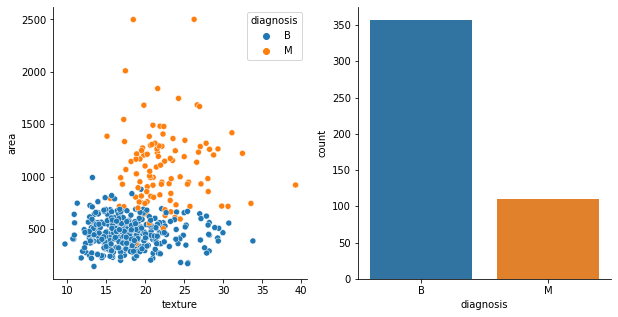

In [4]:
# Plotting the data
fig,axes = plt.subplots(1,2,figsize=(10,5))
sns.scatterplot(x="texture",y="area",hue="diagnosis",data=data,ax=axes[0])
sns.countplot(x=target,ax=axes[1])
sns.despine()

In [5]:
# Splitting data 
 
from sklearn.model_selection import train_test_split
trainx,testx,trainy,testy = train_test_split(features,target,test_size=0.2,stratify=target)
print(f"Dataset Size: {len(data)}")
print(f"Trainset Size: {len(trainx)} ({len(trainx)/len(data)*100:.3}%)")
print(f"Testset Size: {len(testx)} ({len(testx)/len(data)*100:.3}%)")

Dataset Size: 467
Trainset Size: 373 (79.9%)
Testset Size: 94 (20.1%)


# Training Unabalnced Data

In [6]:
# Training on unbalanced data
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.svm import SVC

unbalanced_classifier = SVC()
unbalanced_classifier.fit(trainx,trainy)
predy = unbalanced_classifier.predict(testx)

In [7]:
unbalanced_classification_report = classification_report(testy,predy,output_dict=True)
unbalanced_balanced_accuracy = balanced_accuracy_score(testy,predy)

print("Unbalanced Accuracy Score: ",unbalanced_balanced_accuracy)
print(classification_report(testy,predy))

Unbalanced Accuracy Score:  0.8409090909090908
              precision    recall  f1-score   support

           B       0.91      1.00      0.95        72
           M       1.00      0.68      0.81        22

    accuracy                           0.93        94
   macro avg       0.96      0.84      0.88        94
weighted avg       0.93      0.93      0.92        94



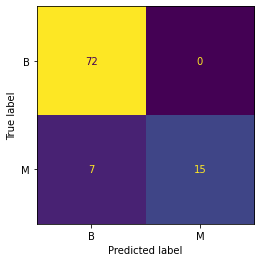

In [8]:
unbalanced_confusion_matrix = confusion_matrix(testy,predy)
cmd = ConfusionMatrixDisplay(unbalanced_confusion_matrix,display_labels=["B","M"])
cmd.plot(colorbar=None)

# Over Sampling

[https://imbalanced-learn.org/stable/](https://imbalanced-learn.org/stable/)

In [10]:
from imblearn.over_sampling import RandomOverSampler,SMOTE,BorderlineSMOTE,ADASYN
oversampler_names = ["RandomOverSampler","SMOTE","BorderlineSMOTE","ADASYN"]
oversamplers = [RandomOverSampler(),SMOTE(),BorderlineSMOTE(),ADASYN()]

oversampled_data = {}

for i,oversampler in enumerate(oversamplers):
	sampledx,sampledy = oversampler.fit_resample(trainx,trainy)
	oversampled_data[oversampler_names[i]] = (sampledx,sampledy)

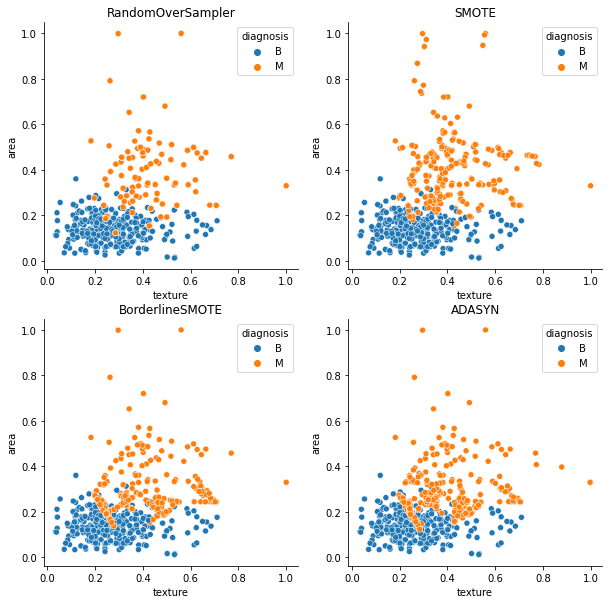

In [12]:
fig,axes = plt.subplots(2,2,figsize=(10,10))
for i,os_name in enumerate(oversampler_names):
	sampledx,sampledy = oversampled_data[os_name]
	sns.scatterplot(x=sampledx.iloc[:,0],y=sampledx.iloc[:,1],hue=sampledy,ax=axes.flatten()[i])
	sns.despine()
	axes.flatten()[i].set_title(oversampler_names[i])

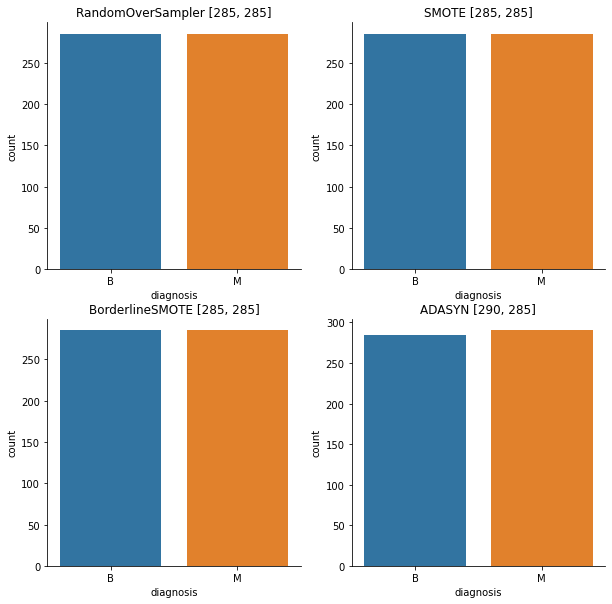

In [13]:
fig,axes = plt.subplots(2,2,figsize=(10,10))
for i,os_name in enumerate(oversampler_names):
	sampledx,sampledy = oversampled_data[os_name]
	sns.countplot(x=sampledy,ax=axes.flatten()[i])
	sns.despine()
	axes.flatten()[i].set_title(f"{oversampler_names[i]} {list(sampledy.value_counts())}")

In [17]:
oversample_classification_report = {}
oversample_confusion_matrix = {}
oversample_balanced_accuracy = {}
for os_name in oversampler_names:
	oversample_classifer = SVC()
	sampledx,sampledy = oversampled_data[os_name]
	oversample_classifer.fit(sampledx,sampledy)
	predy = oversample_classifer.predict(testx)
	oversample_classification_report[os_name] = classification_report(testy,predy,output_dict=True)
	oversample_confusion_matrix[os_name] = confusion_matrix(testy,predy)
	oversample_balanced_accuracy[os_name] = balanced_accuracy_score(testy,predy) 

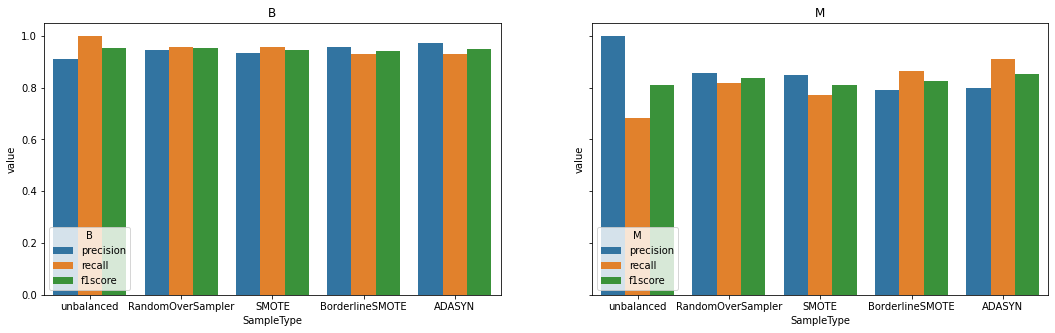

In [19]:
#------------------- Precision Comparison Charts---------------------
# fig,axes = plt.subplots(2,2,figsize=(10,5))
oversample_result_names = ["unbalanced"] + oversampler_names
class_names = ['B','M']
oversample_classification_report['unbalanced'] = unbalanced_classification_report
oversample_balanced_accuracy['unbalanced'] = unbalanced_balanced_accuracy

precisions = [[],[]]
for i in oversample_result_names:
    result = oversample_classification_report[i]
    precisions[0].append(result['B']['precision'])
    precisions[1].append(result['M']['precision'])

recalls = [[],[]]
for i in oversample_result_names:
    result = oversample_classification_report[i]
    recalls[0].append(result['B']['recall'])
    recalls[1].append(result['M']['recall'])

f1scores = [[],[],[]]
for i in oversample_result_names:
    result = oversample_classification_report[i]
    f1scores[0].append(result['B']['f1-score'])
    f1scores[1].append(result['M']['f1-score'])

result_dfs = []
fig,axes = plt.subplots(1,2,figsize=(18,5),sharey=True,sharex=True)

for i,class_name in enumerate(class_names):
    df = pd.DataFrame({
        'SampleType': oversample_result_names,
        'precision': precisions[i],
        'recall': recalls[i],
        'f1score': f1scores[i]
    })
    categorical_df = df.melt(id_vars='SampleType')
    ax = sns.barplot(x="SampleType",y="value",hue="variable",data=categorical_df,ax=axes[i])

    axes[i].legend(title=class_name,loc="lower left")
    axes[i].set_title(class_names[i])



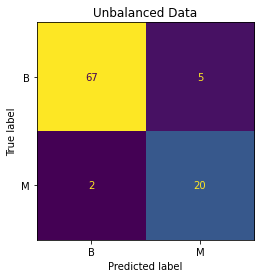

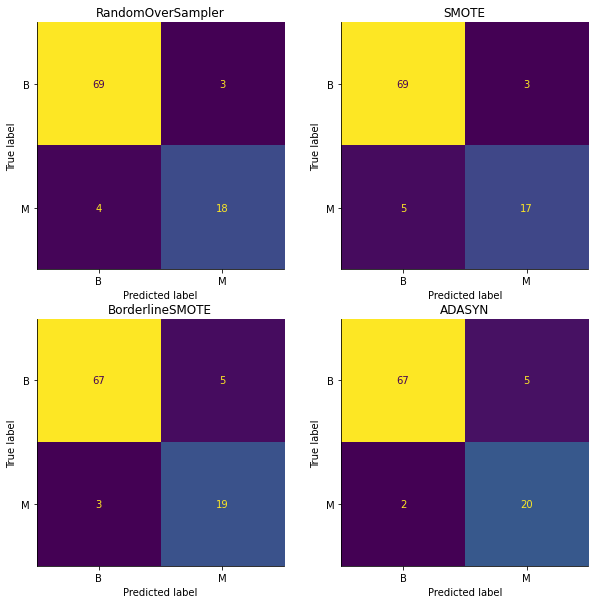

In [21]:
# Plot Confusion Matrices
axs = plt.subplot(1,1,1)
cmd.plot(colorbar=None,ax=axs)
axs.set_title("Unbalanced Data")

fig,axes = plt.subplots(2,2,figsize=(10,10))
for i,os_name in enumerate(oversampler_names):
	cm = oversample_confusion_matrix[os_name]
	cmd = ConfusionMatrixDisplay(cm,display_labels=["B","M"])
	cmd.plot(colorbar=None,ax=axes.flatten()[i])
	sns.despine()
	axes.flatten()[i].set_title(oversampler_names[i])

Accuracy:  [0.925531914893617, 0.925531914893617, 0.9148936170212766, 0.9148936170212766, 0.925531914893617]
Balanced Accuracy:  [0.8409090909090908, 0.8882575757575758, 0.865530303030303, 0.8970959595959596, 0.9198232323232323]


Text(0.5, 1.0, 'Accuracy Vs Balanced Accuracy')

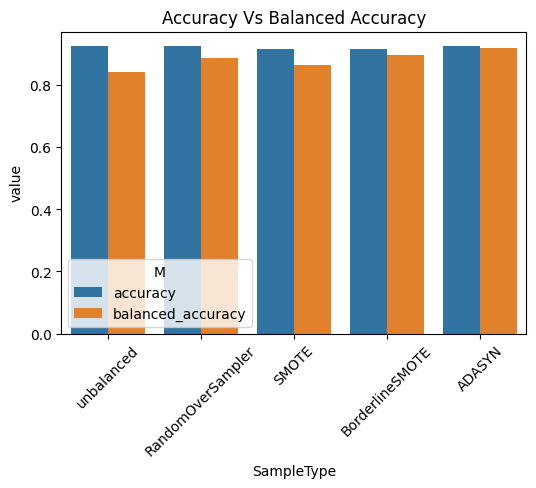

In [22]:
# ----------plotting accuracy vs balanced accuracy------------


plt.figure(dpi=100)
accuracies = []
balanced_accuracies = []
for result in oversample_result_names:
    accuracies.append(oversample_classification_report[result]['accuracy'])
    balanced_accuracies.append(oversample_balanced_accuracy[result])

df = pd.DataFrame({
    'SampleType':oversample_result_names,
    'accuracy':accuracies,
    'balanced_accuracy':balanced_accuracies
})

categorical_df = df.melt(id_vars='SampleType')
ax = sns.barplot(x="SampleType",y="value",hue="variable",data=categorical_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)


ax.legend(title=class_name,loc="lower left")
print("Accuracy: ", accuracies)
print("Balanced Accuracy: ", balanced_accuracies)
plt.title("Accuracy Vs Balanced Accuracy")

# Undersampling

In [23]:
from imblearn.over_sampling import RandomOverSampler,SMOTE,BorderlineSMOTE,ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss, ClusterCentroids
undersampler_names = ["RandomUnderSampler","NearMiss","ClusterCentroids"]
undersamplers = [RandomUnderSampler(),NearMiss(),ClusterCentroids()]

undersampled_data = {}

for i,undersampler in enumerate(undersamplers):
	sampledx,sampledy = undersampler.fit_resample(trainx,trainy)
	undersampled_data[undersampler_names[i]] = (sampledx,sampledy)

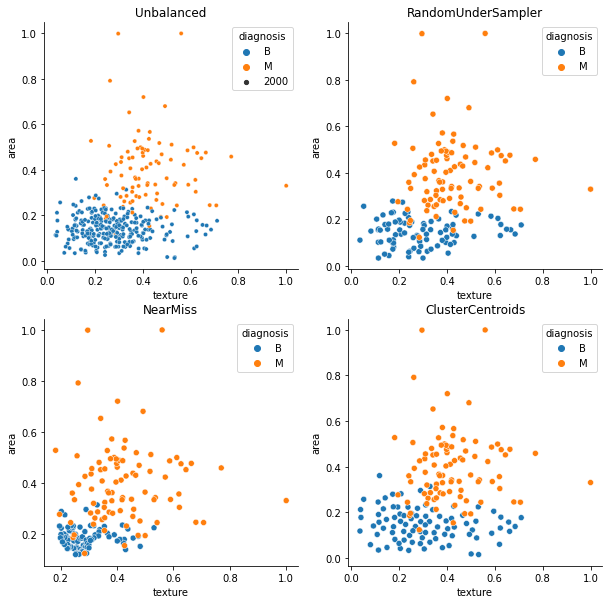

In [24]:
fig,axes = plt.subplots(2,2,figsize=(10,10))

sns.scatterplot(x=trainx.iloc[:,0],y=trainx.iloc[:,1],hue=trainy,ax=axes.flatten()[0],size=2000)
sns.despine()
axes.flatten()[0].set_title("Unbalanced")

for i,os_name in enumerate(undersampler_names):
	sampledx,sampledy = undersampled_data[os_name]
	sns.scatterplot(x=sampledx.iloc[:,0],y=sampledx.iloc[:,1],hue=sampledy,ax=axes.flatten()[i+1])
	sns.despine()
	axes.flatten()[i+1].set_title(undersampler_names[i])

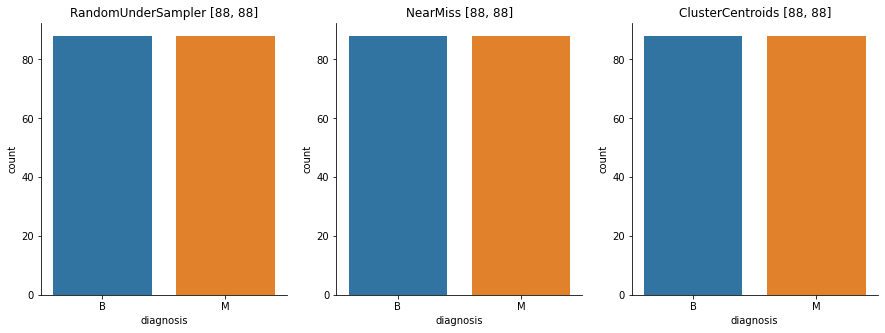

In [69]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
for i,os_name in enumerate(undersampler_names):
	sampledx,sampledy = undersampled_data[os_name]
	sns.countplot(x=sampledy,ax=axes.flatten()[i])
	sns.despine()
	axes.flatten()[i].set_title(f"{undersampler_names[i]} {list(sampledy.value_counts())}")

In [25]:
undersample_classification_report = {}
undersample_confusion_matrix = {}
undersample_balanced_accuracy = {}
for os_name in undersampler_names:
	undersample_classifer = SVC()
	sampledx,sampledy = undersampled_data[os_name]
	undersample_classifer.fit(sampledx,sampledy)
	predy = undersample_classifer.predict(testx)
	undersample_classification_report[os_name] = classification_report(testy,predy,output_dict=True)
	undersample_confusion_matrix[os_name] = confusion_matrix(testy,predy)
	undersample_balanced_accuracy[os_name] = balanced_accuracy_score(testy,predy) 

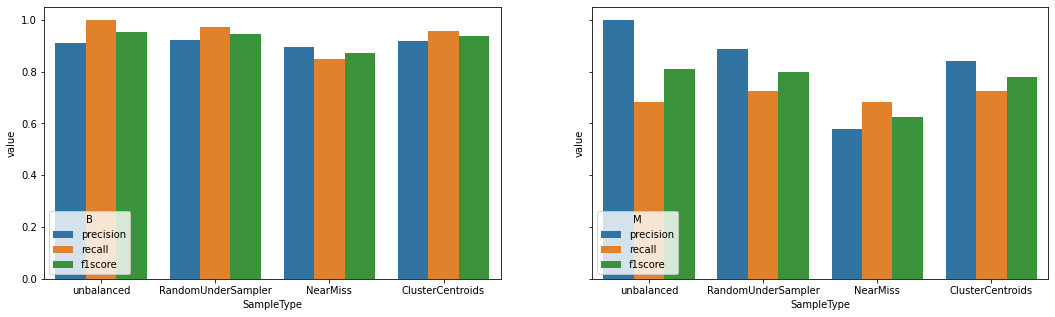

In [26]:
#------------------- Precision Comparison Charts---------------------
# fig,axes = plt.subplots(2,2,figsize=(10,5))
undersample_result_names = ["unbalanced"] + undersampler_names
class_names = ['B','M']
undersample_classification_report['unbalanced'] = unbalanced_classification_report
undersample_balanced_accuracy['unbalanced'] = unbalanced_balanced_accuracy

precisions = [[],[]]
for i in undersample_result_names:
    result = undersample_classification_report[i]
    precisions[0].append(result['B']['precision'])
    precisions[1].append(result['M']['precision'])

recalls = [[],[]]
for i in undersample_result_names:
    result = undersample_classification_report[i]
    recalls[0].append(result['B']['recall'])
    recalls[1].append(result['M']['recall'])

f1scores = [[],[],[]]
for i in undersample_result_names:
    result = undersample_classification_report[i]
    f1scores[0].append(result['B']['f1-score'])
    f1scores[1].append(result['M']['f1-score'])

result_dfs = []
fig,axes = plt.subplots(1,2,figsize=(18,5),sharey=True,sharex=True)

for i,class_name in enumerate(class_names):
    df = pd.DataFrame({
        'SampleType': undersample_result_names,
        'precision': precisions[i],
        'recall': recalls[i],
        'f1score': f1scores[i]
    })
    categorical_df = df.melt(id_vars='SampleType')
    ax = sns.barplot(x="SampleType",y="value",hue="variable",data=categorical_df,ax=axes[i])

    axes[i].legend(title=class_name,loc="lower left")



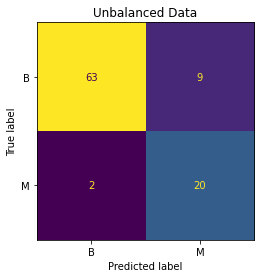

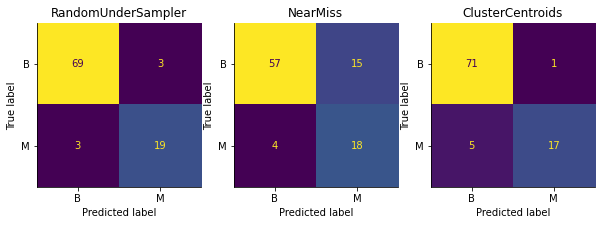

In [80]:
# Plot Confusion Matrices
axs = plt.subplot(1,1,1)
cmd.plot(colorbar=None,ax=axs)
axs.set_title("Unbalanced Data")

fig,axes = plt.subplots(1,3,figsize=(15,10))
for i,os_name in enumerate(undersampler_names):
	cm = undersample_confusion_matrix[os_name]
	cmd = ConfusionMatrixDisplay(cm,display_labels=["B","M"])
	cmd.plot(colorbar=None,ax=axes.flatten()[i])
	sns.despine()
	axes.flatten()[i].set_title(undersampler_names[i])

Accuracy:  [0.9468085106382979, 0.9361702127659575, 0.7978723404255319, 0.9361702127659575]
Balanced Accuracy:  [0.8863636363636364, 0.9109848484848485, 0.8049242424242424, 0.8794191919191919]


Text(0.5, 1.0, 'Accuracy Vs Balanced Accuracy')

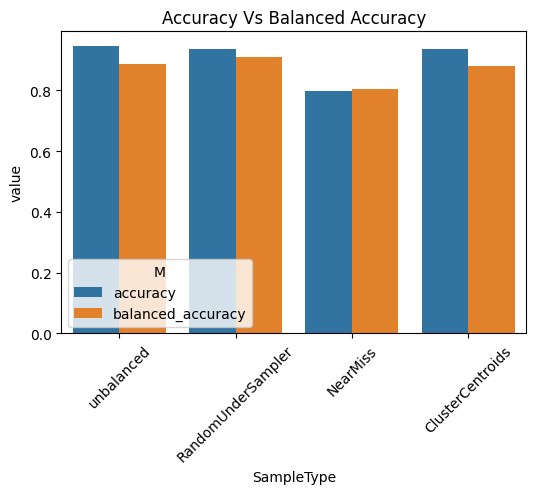

In [82]:
# ----------plotting accuracy vs balanced accuracy------------


plt.figure(dpi=100)
accuracies = []
balanced_accuracies = []
for result in undersample_result_names:
    accuracies.append(undersample_classification_report[result]['accuracy'])
    balanced_accuracies.append(undersample_balanced_accuracy[result])

df = pd.DataFrame({
    'SampleType':undersample_result_names,
    'accuracy':accuracies,
    'balanced_accuracy':balanced_accuracies
})

categorical_df = df.melt(id_vars='SampleType')
ax = sns.barplot(x="SampleType",y="value",hue="variable",data=categorical_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)


ax.legend(title=class_name,loc="lower left")
print("Accuracy: ", accuracies)
print("Balanced Accuracy: ", balanced_accuracies)
plt.title("Accuracy Vs Balanced Accuracy")

# Ensemble 

# Bagging

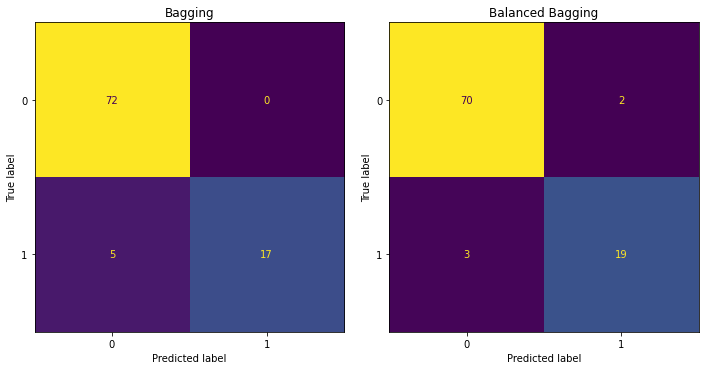

In [83]:
from sklearn.ensemble import BaggingClassifier
from imblearn.ensemble import BalancedBaggingClassifier

bagging = BaggingClassifier(n_estimators=50, random_state=0)
balanced_bagging = BalancedBaggingClassifier(n_estimators=50, random_state=0)

bagging.fit(trainx, trainy)
balanced_bagging.fit(trainx, trainy)

y_pred_bc = bagging.predict(testx)
y_pred_bbc = balanced_bagging.predict(testx)


fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
cm_bc = confusion_matrix(testy,y_pred_bc)
cmd_bc = ConfusionMatrixDisplay(cm_bc)
cmd_bc.plot(ax=axs[0],colorbar=None)
axs[0].set_title("Bagging")

cm_bbc = confusion_matrix(testy,y_pred_bbc)
cmd_bbc = ConfusionMatrixDisplay(cm_bbc)
cmd_bbc.plot(ax=axs[1],colorbar=None)
axs[1].set_title("Balanced Bagging")

fig.tight_layout()

## Boosting

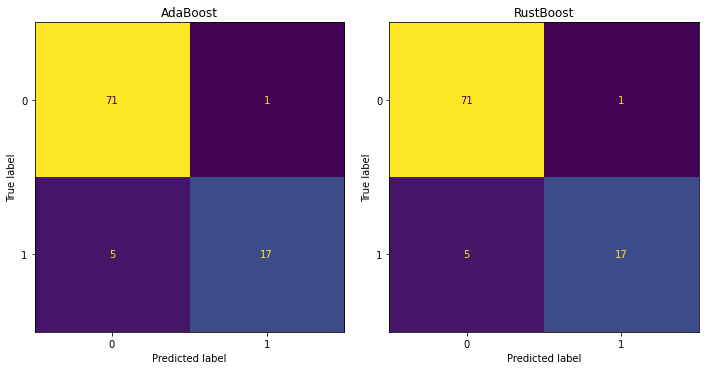

In [84]:
from sklearn.ensemble import AdaBoostClassifier
from imblearn.ensemble import EasyEnsembleClassifier, RUSBoostClassifier


# eec = EasyEnsembleClassifier(n_estimators=10, base_estimator=base_estimator)
# eec.fit(trainx, trainy)
# y_pred_eec = eec.predict(testx)

rusboost = RUSBoostClassifier(n_estimators=10, base_estimator=AdaBoostClassifier(n_estimators=10))
rusboost.fit(trainx, trainy)
y_pred_rusboost = rusboost.predict(testx)


abc = AdaBoostClassifier(n_estimators=10)
abc.fit(trainx,trainy)
y_pred = abc.predict(testx)

fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

abc_cm = confusion_matrix(testy,y_pred)
rbc_cm = confusion_matrix(testy,y_pred_rusboost)

abc_cmd = ConfusionMatrixDisplay(abc_cm)
rbc_cmd = ConfusionMatrixDisplay(rbc_cm)

abc_cmd.plot(ax=axs[0], colorbar=False)
rbc_cmd.plot(ax=axs[1], colorbar=False)
axs[0].set_title("AdaBoost")
axs[1].set_title("RustBoost")
fig.tight_layout()
plt.show()